#### System and data taken from [Chan et. al 2023](https://ieeexplore.ieee.org/document/10156650/)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from casadi import *
from copy import *
import scipy.io

### Loading in information

In [2]:
#model = scipy.io.loadmat('data/APPJmodel_2021_06_08_15h57m55s_n4sid_alldata.mat')
model = scipy.io.loadmat('data/mat/subspace_id.mat') # 5 state model 

Np = 10 # prediction horizon
Ns = 60 # simulation horizon
ts = 0.5 # sampling time
Tref = 43.0 # reference temperature
Tmax = 45.0 # max temp. for patient comfort
Kcem = 0.5 

In [3]:
# state, input, state-transition, and observation matrices
A, B, C = model['A'], model['B'], model['C']
nx, nu, ny, nyc = A.shape[0], B.shape[1], C.shape[0], 1

yss = np.ravel(model['yss']) # use to center data for controller [Ts, I]
uss = np.ravel(model['uss']) # use to center data for controller [P, q]

# constraint bounds, centered about ss
u_min = np.array([1.5, 3.5]) - uss
u_max = np.array([3.5, 7.5]) - uss
y_min = np.array([25, 0]) - yss
y_max = np.array([Tmax, 80]) - yss

# just assume that the values begin at equilibrium
u_init = np.zeros(nu)
y_init = np.zeros(ny)
x_init = np.zeros(nx) 

# covariance process noise, covariance observation noise, 
# initial covariance matrix, initial estimated state
Qw = np.random.normal(loc=0.0, scale=1.0, size=(nx, nx))
Rv = np.random.normal(loc=0.0, scale=10E-3, size=(nu, nu)) # suggestion by Ali
P_init = np.random.normal(loc=0.0, scale=1.0, size=(nx, nx))
xhat_init = np.zeros(nx) 

### Set up controller

In [4]:
opti = Opti() 

x = SX.sym('x', nx)
u = SX.sym('u', nu)
y = SX.sym('y', ny)

# Linearized equations based on deviation values centered around ss
f = Function('f', [x, u], [A@x + B@u])
h = Function('h', [x], [C@x])

# nonlinear CEM requires absolute Ts 
lstg = (Kcem ** (Tref - (y[0] + yss[0])) ) * ts / 60
lstage = Function('lstage', [y], [lstg])
CEM = ( Kcem ** (Tref - (y[0] + yss[0])) ) * ts / 60
CEMadd = Function('CEMadd', [y], [CEM])

# containers
X = [0 for _ in range(Np + 1)]
U = [0 for _ in range(Np)]
Y = [0 for _ in range(Np + 1)]
J = 0

CEMref = opti.parameter(nyc) # target/reference output, fixed during optimization
opti.set_value(CEMref, np.zeros(nyc)) # set value of parameter
CEM0 = opti.parameter(nyc) # initial CEM 
opti.set_value(CEM0, np.zeros(nyc)) # set value of initial CEM parameter

X[0] = opti.parameter(nx) # initial state as parameter
opti.set_value(X[0], np.zeros(nx)) # set value of initial state parameter
Y[0] = opti.variable(ny) # output as decision variable 
opti.subject_to(Y[0] == h(X[0])) # define output constraints based on initial state
opti.set_initial(Y[0], y_init) # define initial output 

for k in range(Np): 
    # controller @ k
    U[k] = opti.variable(nu) # controller input as decision variable
    opti.subject_to(opti.bounded(u_min, U[k], u_max)) # define controller input constraints
    opti.set_initial(U[k], u_init) # define initial controller input

    # increment stage cost 
    Jstage = lstage(Y[k])
    J += Jstage

    # state @ k+1
    X[k + 1] = opti.variable(nx) # state at k+1 as decision variable
    # opti.subject_to(opti.bounded(x_min, X[k + 1], x_max)) # define state constraints
    opti.set_initial(X[k + 1], x_init) # define initial state 

    # output @ k+1
    Y[k + 1] = opti.variable(ny) # output at k+1 as decision variable
    opti.subject_to(opti.bounded(y_min, Y[k + 1], y_max)) # define output constraints
    opti.set_initial(Y[k + 1], y_init) # define initial output

    # dynamics constraint
    opti.subject_to(X[k + 1] == f(X[k], U[k]))
    # output equality constraint
    opti.subject_to(Y[k + 1] == h(X[k + 1]))

# calculate the terminal cost, note no splits or iterations
J += lstage(Y[-1])
J = (CEMref - (J + CEM0)) ** 2 # eq. 6 control objective 

# minimize cost
opti.minimize(J)

p_opts = {'verbose': False, 'expand': True, 'print_time': 1} # options taken from K.C. --> Ipopt options to print to console
s_opts = {'max_iter': 1000, 'print_level': 1, 'tol': 1e-6}

opti.solver('ipopt', p_opts, s_opts)

soln = opti.solve()


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  | 226.00us ( 20.55us)  15.67us (  1.42us)        11
       nlp_g  | 586.00us ( 53.27us)  39.11us (  3.56us)        11
  nlp_grad_f  | 348.00us ( 29.00us)  23.96us (  2.00us)        12
  nlp_hess_l  | 321.00us ( 32.10us)  22.85us (  2.29us)        10
   nlp_jac_g  | 585.00us ( 48.75us)  42.12us (  3.51us)        12
       total  | 256.56ms (256.56ms)  18.88ms ( 18.88ms)         1


#### Validate the KF implementation by running an open-loop sim

We are trying to compare the plants measurements to the estimated states output by the KF

In [5]:
# containers
X_plant = np.zeros((nx, Np + 1)) 
Y_plant = np.zeros((ny, Np + 1))

X_est = np.zeros((nx, Np + 1))
P_est = np.zeros((Np + 1, nx, nx))

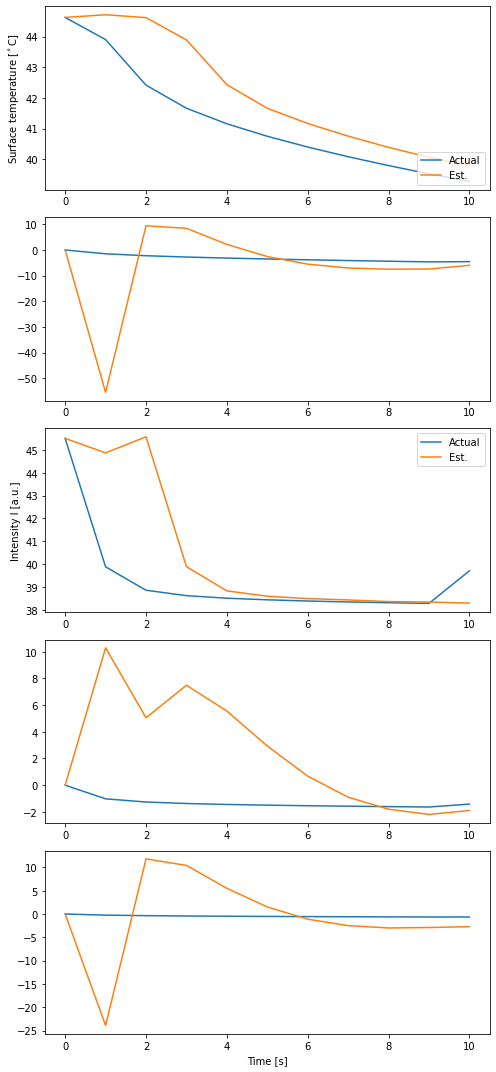

In [6]:
# @ k = 0
# get U inputs from running controller once
U_kf_test = np.asarray([soln.value(u) for u in U]).reshape(-1, nu).T

# initialize the plant state
X_plant[:, 0] = np.ravel(x_init)

# run plant @ k=0, get the first observable result and corrupt with noise
Y_plant[:, 0] = np.ravel((h(X_plant[:, 0])).full())
Y_plant[:, 0][0] += np.random.normal(loc=0., scale=10E-3)
Y_plant[:, 0][1] += np.random.normal(loc=0., scale=10E-3)

# initialize KF
X_est[:, 0] = np.zeros(nx)
P_est[0] = P_init

for k in range(Np):
    
    # --- KALMAN FILTER ---
    # A priori estimate, prediction
    xphat = A @ X_est[:, k] + B @ U_kf_test[:, k] # xhat{k+1, k}
    Pphat = A @ P_est[k] @ np.transpose(A) + Qw # Pphat{k+1, k}

    # Measurement update, correction
    # * Compute Kalman gain
    yr = Y_plant[:, k] - (C @ xphat) # Measurement pre-fit residual
    Sk = C @ Pphat @ np.transpose(C) + Rv # Innovation/pre-fit residual covariance
    Kk = Pphat @ np.transpose(C) @ inv(Sk) # Optimal Kalman gain
    # * Update estimate with measurement and uncertainty
    xhat = xphat + Kk @ yr
    Phat = np.identity(A.shape[0]) - Kk @ C @ Pphat
    
    # storage kalman filter states
    X_est[:, k + 1] = np.ravel(xhat)
    P_est[k + 1] = Phat
    # ----------------------

    # run the plant again
    X_plant[:, k + 1] = np.ravel(f(X_plant[:, k], U_kf_test[:, k]).full())
    
    # obtain the y output, corrupt it with 0-mean noise
    Y_plant[:, k + 1] = np.ravel(h(X_plant[:, k]).full())
    Y_plant[:, k + 1][0] += np.random.normal(loc=0., scale=10E-3)
    Y_plant[:, k + 1][1] += np.random.normal(loc=0., scale=10E-3)

xp_axis = np.arange(Np + 1)
fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(5, figsize=(7, 15))   

# State 1
ax1.plot(xp_axis, np.ravel(X_plant[0]) + yss[0], label='Actual')
ax1.plot(xp_axis, np.ravel(X_est[0]) + yss[0], label='Est.')
ax1.set_ylabel('Surface temperature [$^\circ$C]')
ax1.legend(loc='lower right')

# State 2
ax3.plot(xp_axis, np.ravel(X_plant[2]) + yss[1], label='Actual')
ax3.plot(xp_axis, np.ravel(X_est[2]) + yss[1], label='Est.')
ax3.set_ylabel('Intensity I [a.u.]')
ax3.legend()

ax2.plot(xp_axis, np.ravel(X_plant[1]), label='actual')
ax2.plot(xp_axis, np.ravel(X_est[1]), label='est.')
ax2.set_ylabel('')

ax4.plot(xp_axis, np.ravel(X_plant[3]), label='actual')
ax4.plot(xp_axis, np.ravel(X_est[3]), label='est.')
ax4.set_ylabel('')

ax5.plot(xp_axis, np.ravel(X_plant[4]), label='actual')
ax5.plot(xp_axis, np.ravel(X_est[4]), label='est.')
ax5.set_ylabel('')

ax5.set_xlabel('Time [s]')
plt.tight_layout()

### Run closed-loop simulation with Kalman filter

In [7]:
U_sim = np.zeros((nu, Ns))
X_sim = np.zeros((nx, Ns + 1))
Y_sim = np.zeros((ny, Ns + 1))
CEMsim = np.zeros((nyc, Ns + 1))
X_est = np.zeros((nx, Ns + 1))
P_est = np.zeros((Ns + 1, nx, nx))

X_sim[:, 0] = np.ravel(x_init) 

Y_sim[:, 0] = np.ravel(h(X_sim[:, 0]).full())
Y_sim[:, 0][0] += np.random.normal(loc=0., scale=10E-3)
Y_sim[:, 0][1] += np.random.normal(loc=0., scale=10E-3)

CEMsim[:, 0] = np.zeros((nyc,))

X_est[:, 0] = np.zeros(nx)
P_est[0] = P_init

In [8]:
# run closed-loop
for k in range(Ns):    
    opti.set_value(X[0], X_sim[:, k]) # set initial state parameters 
    #CEMref and CEM0
    opti.set_value(CEMref, 1.5)
    
    opti.set_value(CEM0, CEMsim[:, k])
    sol = opti.solve() # solve using the controller
    U_soln = np.asarray([sol.value(u) for u in U]).reshape(nu, -1) # extract control inputs based on state

    U_sim[:, k] = U_soln[:, 0] # for control, only interested in the first opt. control input
    
    # --- KALMAN FILTER ---
    # A priori estimate, prediction
    xphat = A @ X_est[:, k] + B @ U_sim[:, k] # xhat{k+1, k}
    Pphat = A @ P_est[k] @ np.transpose(A) + Qw # Pphat{k+1, k}

    # Measurement update, correction
    # * Compute Kalman gain
    yr = Y_sim[:, k] - (C @ xphat) # Measurement pre-fit residual
    Sk = C @ Pphat @ np.transpose(C) + Rv # Innovation/pre-fit residual covariance
    Kk = Pphat @ np.transpose(C) @ inv(Sk) # Optimal Kalman gain
    # * Update estimate with measurement and uncertainty
    xhat = xphat + Kk @ yr
    Phat = np.identity(A.shape[0]) - Kk @ C @ Pphat
    
    # store kalman filter states
    X_est[:, k + 1] = np.ravel(xhat)
    P_est[k + 1] = Phat
    # ----------------------
    
    X_sim[:, k + 1] = np.ravel(f(X_sim[:, k], U_sim[:, k]).full()) # apply input to state system/plant
    Y_sim[:, k + 1] = np.ravel(h(X_sim[:, k + 1]).full()) # apply input to output system/plant
    Y_sim[:, k + 1][0] += np.random.normal(loc=0., scale=10E-3)
    Y_sim[:, k + 1][1] += np.random.normal(loc=0., scale=10E-3)
    
    CEMsim[:, k + 1] = CEMsim[:, k] + np.ravel(CEMadd(Y_sim[:, k + 1]).full())
    

      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  | 237.00us ( 13.17us)  24.22us (  1.35us)        18
       nlp_g  | 612.00us ( 34.00us)  60.49us (  3.36us)        18
    nlp_grad  |  77.00us ( 77.00us)   5.52us (  5.52us)         1
  nlp_grad_f  | 363.00us ( 18.15us)  38.76us (  1.94us)        20
  nlp_hess_l  | 337.00us ( 21.06us)  37.17us (  2.32us)        16
   nlp_jac_g  | 615.00us ( 30.75us)  71.87us (  3.59us)        20
       total  |   5.65ms (  5.65ms)   5.60ms (  5.60ms)         1
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  | 249.00us (  9.22us)  32.29us (  1.20us)        27
       nlp_g  | 633.00us ( 23.44us)  78.91us (  2.92us)        27
    nlp_grad  |  84.00us ( 42.00us)  12.04us (  6.02us)         2
  nlp_grad_f  | 375.00us ( 12.50us)  50.25us (  1.68us)        30
  nlp_hess_l  | 351.00us ( 14.63us)  50.70us (  2.11us)        24
   nlp_jac_g  | 636.00us ( 21.20us)  96.23us (  3.21us)        30
       tot

      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  | 543.00us (  1.80us) 279.42us (928.29ns)       301
       nlp_g  |   1.44ms (  4.79us) 738.08us (  2.45us)       301
    nlp_grad  | 309.00us (  9.36us) 237.71us (  7.20us)        33
  nlp_grad_f  | 786.00us (  2.35us) 433.90us (  1.30us)       335
  nlp_hess_l  | 819.00us (  3.07us) 485.65us (  1.82us)       267
   nlp_jac_g  |   1.40ms (  4.17us) 851.29us (  2.54us)       335
       total  |   5.34ms (  5.34ms)   5.33ms (  5.33ms)         1
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  | 555.00us (  1.78us) 299.54us (960.06ns)       312
       nlp_g  |   1.47ms (  4.71us) 761.67us (  2.44us)       312
    nlp_grad  | 313.00us (  9.21us) 241.74us (  7.11us)        34
  nlp_grad_f  | 801.00us (  2.31us) 447.39us (  1.29us)       347
  nlp_hess_l  | 838.00us (  3.03us) 502.26us (  1.81us)       277
   nlp_jac_g  |   1.43ms (  4.11us) 879.89us (  2.54us)       347
       tot

### Plotting

State and input profiles of closed-loop experiments for a single iteration

States  X (CEM, Ts)

Control U (P  , q )

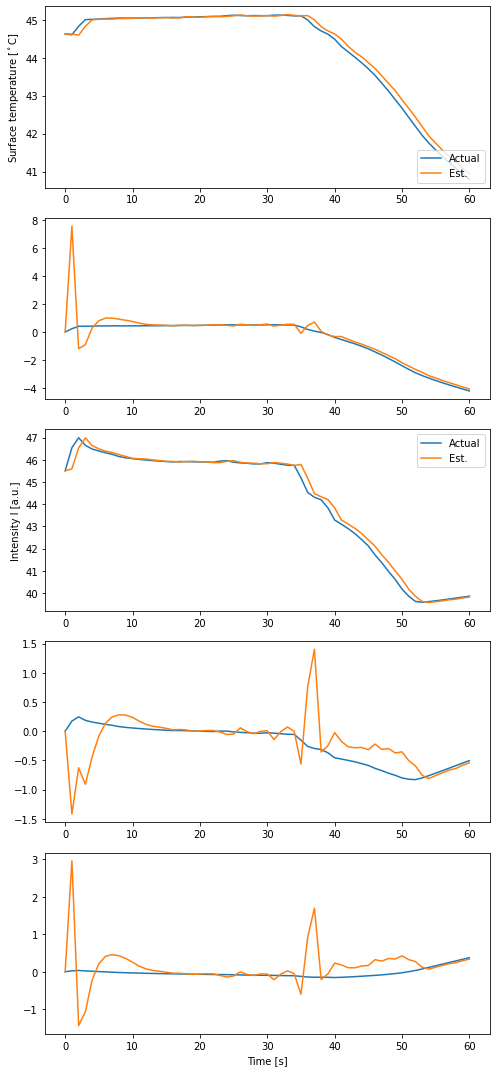

In [9]:
x_axis = np.arange(Ns + 1)
fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(5, figsize=(7, 15))   

# State 1
ax1.plot(np.arange(Ns + 1), np.ravel(X_sim[0]) + yss[0], label='Actual')
ax1.plot(np.arange(Ns + 1), np.ravel(X_est[0]) + yss[0], label='Est.')
ax1.set_ylabel('Surface temperature [$^\circ$C]')
ax1.legend(loc='lower right')

# State 2
ax3.plot(np.arange(Ns + 1), np.ravel(X_sim[2]) + yss[1], label='Actual')
ax3.plot(np.arange(Ns + 1), np.ravel(X_est[2]) + yss[1], label='Est.')
ax3.set_ylabel('Intensity I [a.u.]')
ax3.legend()

ax2.plot(x_axis, np.ravel(X_sim[1]), label='actual')
ax2.plot(x_axis, np.ravel(X_est[1]), label='est.')
ax2.set_ylabel('')

ax4.plot(x_axis, np.ravel(X_sim[3]), label='actual')
ax4.plot(x_axis, np.ravel(X_est[3]), label='est.')
ax4.set_ylabel('')

ax5.plot(x_axis, np.ravel(X_sim[4]), label='actual')
ax5.plot(x_axis, np.ravel(X_est[4]), label='est.')
ax5.set_ylabel('')

ax5.set_xlabel('Time [s]')
plt.tight_layout()

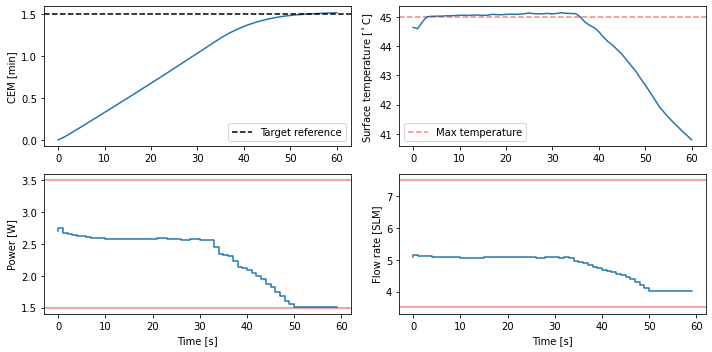

In [11]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(10, 5)) 
# # I
# ax2.plot(np.arange(Y_sim[1].shape[0]), np.ravel(Y_sim[1]) + yss[1])
# ax2.set_ylabel('I [a.u.]')

# CEM
ax1.plot(np.arange(CEMsim.shape[1]), np.ravel(CEMsim))
ax1.axhline([1.5], linestyle='--', color='black', label='Target reference')
ax1.set_ylabel('CEM [min]')
ax1.legend()

# Ts
ax2.plot(np.arange(Y_sim[0].shape[0]), np.ravel(Y_sim[0]) + yss[0])
ax2.axhline([45.], color='red', linestyle='--', label='Max temperature', alpha=0.5)
ax2.set_ylabel('Surface temperature [$^\circ$C]')
ax2.legend()

# P
ax3.step(np.arange(U_sim[0].shape[0]), np.ravel(U_sim[0]) + uss[0])
ax3.axhline([u_max[0] + uss[0]], color='r', alpha=0.5)
ax3.axhline([u_min[0] + uss[0]], color='r', alpha=0.5)
ax3.set_ylabel('Power [W]')
ax3.set_xlabel('Time [s]')
# q
ax4.step(np.arange(U_sim[1].shape[0]), np.ravel(U_sim[1]) + uss[1])
ax4.axhline([u_max[1] + uss[1]], color='r', alpha=0.5)
ax4.axhline([u_min[1] + uss[1]], color='r', alpha=0.5)
ax4.set_ylabel('Flow rate [SLM]')
ax4.set_xlabel('Time [s]')

plt.tight_layout()